In [1]:
!ls /usr/local/cuda*

/usr/local/cuda:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11.2:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json


In [2]:
!nvidia-smi

Fri Dec 16 15:10:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli ../../bin/x86_64/linux/release/simpleOccupancy

==ERROR== '../../bin/x86_64/linux/release/simpleOccupancy' does not exist or is not an executable. Please make sure to specify the absolute path to '../../bin/x86_64/linux/release/simpleOccupancy' if the executable is not in the local directory.


In [34]:
%%writefile vectorAdd.cu


#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <sys/time.h>
 
// CUDA kernel. Each thread takes care of one element of c
__global__ void vecAdd(double *a, double *b, double *c, int n)
{
    // Get our global thread ID
    int id = blockIdx.x*blockDim.x+threadIdx.x;
 
    // Make sure we do not go out of bounds
    if (id < n)
        c[id] = a[id] + b[id];
}

double cpuSecond() {
   struct timeval tp;
   gettimeofday(&tp,NULL);
   return ((double)tp.tv_sec + (double)tp.tv_usec*1.e-6);
}
 
int main( int argc, char* argv[] )
{
    // Size of vectors
    int n = 1024;
 
    // Host input vectors
    double *h_a;
    double *h_b;
    //Host output vector
    double *h_c;
 
    // Device input vectors
    double *d_a;
    double *d_b;
    //Device output vector
    double *d_c;
 
    // Size, in bytes, of each vector
    size_t bytes = n*sizeof(double);
 
    // Allocate memory for each vector on host
    h_a = (double*)malloc(bytes);
    h_b = (double*)malloc(bytes);
    h_c = (double*)malloc(bytes);
 
    // Allocate memory for each vector on GPU
    cudaMalloc(&d_a, bytes);
    cudaMalloc(&d_b, bytes);
    cudaMalloc(&d_c, bytes);
 
    int i;
    // Initialize vectors on host
    for( i = 0; i < n; i++ ) {
        h_a[i] = sin(i)*sin(i);
        h_b[i] = cos(i)*cos(i);
    }
 
    // Copy host vectors to device
    //TIME THIS
    double hTdTime = cpuSecond();
    cudaMemcpy( d_a, h_a, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy( d_b, h_b, bytes, cudaMemcpyHostToDevice);
    cudaDeviceSynchronize();
    double hTdTimeElapsed = cpuSecond() - hTdTime;
 
    int blockSize, gridSize;
 
    // Number of threads in each thread block
    blockSize = 1024;
 
    // Number of thread blocks in grid
    gridSize = (int)ceil((float)n/blockSize);
 
    // Execute the kernel
    //TIME THIS
    double kernelTime = cpuSecond();
    vecAdd<<<gridSize, blockSize>>>(d_a, d_b, d_c, n);
    cudaDeviceSynchronize();
    double kernelTimeElapsed = cpuSecond() - kernelTime;

    // Copy array back to host
    //TIME THIS
    double dThTime = cpuSecond();
    cudaMemcpy( h_c, d_c, bytes, cudaMemcpyDeviceToHost );
    cudaDeviceSynchronize();
    double dThTimeElapsed = cpuSecond() - dThTime;
 
    // Sum up vector c and print result divided by n, this should equal 1 within error
    double sum = 0;
    for(i=0; i<n; i++)
        sum += h_c[i];
    printf("final result: %f\n", sum/n);
 
    // Release device memory
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
 
    // Release host memory
    free(h_a);
    free(h_b);
    free(h_c);


    printf("Host to Device: %f\n", hTdTimeElapsed);
    printf("Kernel: %f\n", kernelTimeElapsed);
    printf("Device to Host: %f\n", dThTimeElapsed);
 
    return 0;
}


Overwriting vectorAdd.cu


In [23]:
!nvcc vectorAdd.cu -o vectorAdd

In [24]:
!./vectorAdd

final result: 1.000000
Host to Device: 0.003475
Kernel: 0.000113
Device to Host: 0.005172


In [6]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli vectorAdd

==PROF== Connected to process 178 (/content/vectorAdd)
==PROF== Profiling "vecAdd" - 1: 0%....50%....100% - 8 passes
final result: 1.000000
==PROF== Disconnected from process 178
[178] vectorAdd@127.0.0.1
  vecAdd(double*, double*, double*, int), 2022-Dec-15 17:42:27, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           5.13
    SM Frequency                                                             cycle/usecond                         600.21
    Elapsed Cycles                                                                   cycle                          8,434
    Memory [%]                                                                           %                          50.56
    SOL DRAM                                                         

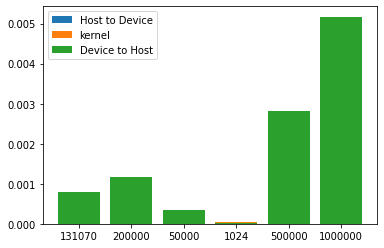

In [33]:
#Graphing

#storing the data
#Size = 131070:
  # Host to Device: 0.000641
  # Kernel: 0.000043
  # Device to Host: 0.000798

#Size = 200000:
  # Host to Device: 0.000768
  # Kernel: 0.000064
  # Device to Host: 0.001162

#Size = 50000:
  # Host to Device: 0.000272
  # Kernel: 0.000028
  # Device to Host: 0.000342

#Size = 1024:
  # Host to Device: 0.000034
  # Kernel: 0.000049
  # Device to Host: 0.000023

#Size = 500000:
  # Host to Device: 0.001810
  # Kernel: 0.000066
  # Device to Host: 0.002822

#Size = 1000000:
  # Host to Device: 0.003475
  # Kernel: 0.000113
  # Device to Host: 0.005172


import matplotlib.pyplot as plt

# Data for the bar chart
x = ['131070', '200000', '50000', '1024', '500000', '1000000']
y1 = [0.000641, 0.000768, 0.000272, 0.000034, 0.001810, 0.003475]
y2 = [0.000043, 0.000064, 0.000028, 0.000049, 0.000066, 0.000113]
y3 = [0.000798, 0.001162, 0.000342, 0.000023, 0.002822, 0.005172]

# Create the figure and the axis


# Add the data to the plot
plt.bar(x, y1, label="Host to Device")
plt.bar(x, y2, label="kernel")
plt.bar(x, y3, label="Device to Host")

# Add labels and title
# plt.set_xlabel("Vector size")
# plt.set_ylabel("Time taken")
# plt.set_title("Time taken based on Vector size")
plt.legend()

# Show the plot
plt.show()
